<a href="https://colab.research.google.com/github/TonyJacb/Convolutional-Autoencoder-for-MRI-Denoising/blob/main/Conv_Autoencoder_Rev3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Autoencoder for denoising of Brain MR Images

### Import dataset

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/data

/content/gdrive/My Drive/data


### Preprocessing functions

In [ ]:
import numpy as np
import cv2
import random

def img_preprocess(img):
  img = cv2.resize(img,(544,544))
  return img

def sp_noise(image,prob):
  output = np.zeros(image.shape, np.uint8)
  thres = 1-prob
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      rdn = random.random()
      if rdn < prob:
        output[i][j] = 0
      elif rdn > thres:
        output[i][j] = 255
      else:
        output[i][j] = image[i][j]
  return output

### Test Images

(225, 225)

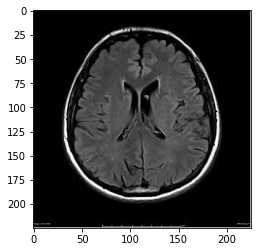

In [ ]:
import matplotlib.pyplot as plt
img = cv2.imread('5 no.jpg',0)
plt.imshow(img,cmap = 'gray')
img.shape

(544, 544)

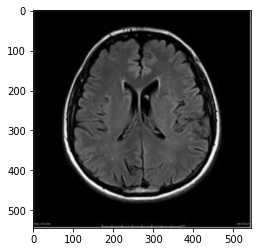

In [ ]:
img = cv2.imread('5 no.jpg',0)
img = img_preprocess(img)
img_noised = sp_noise(img,.02)
plt.imshow(img,cmap = 'gray')
img.shape

### Test cv2 method of Denoising

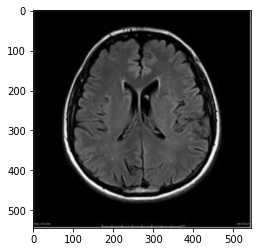

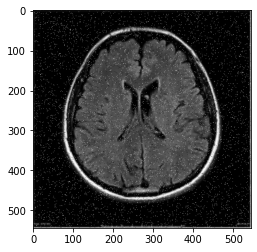

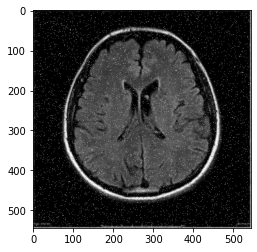

In [ ]:
img_denoised = cv2.fastNlMeansDenoising(img_noised)
plt.figure()
plt.imshow(img,cmap="gray")
plt.figure()
plt.imshow(img_noised,cmap="gray")
plt.figure()
plt.imshow(img_denoised,cmap="gray")

####Mean Squared Error

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [ ]:
mse(img,img_denoised)

1060.0032338073097

####SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim
ssim(img_denoised, img)

0.4224165220885019

####PSNR

In [ ]:
import math
def compute_psnr(img1, img2):
  img1 = img1.astype(np.float32) / 255.
  img2 = img2.astype(np.float32) / 255.
  mse = np.mean((img1 - img2) ** 2)
  if mse == 0:
    return "Same Image"
  return 10 * math.log10(1. / mse)

In [ ]:
compute_psnr(img_denoised,img)

17.877731349473514

### Images to numpy arrays

In [ ]:
import os
x_train = []
x_train_noisy = []
PATH = "./"
for file in os.listdir(PATH):
  if file.endswith(".jpg") or file.endswith(".JPG") or file.endswith(".jpeg") or file.endswith("png"):
    img = cv2.imread(os.path.join(PATH,file),0)
    img = img_preprocess(img)
    img.astype("float32")
    x_train.append(img/255)
    img_noise = sp_noise(img,.02)
    img_noise.astype("float32")
    x_train_noisy.append(img_noise/255)
x_train_noisy = np.asarray(x_train_noisy)
x_train = np.asarray(x_train)

In [ ]:
x_train = np.float32(x_train)
x_train_noisy = np.float32(x_train_noisy)

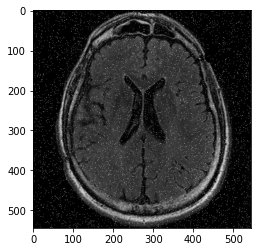

In [ ]:
plt.imshow(x_train_noisy[56],cmap = 'gray')

In [ ]:
if len(x_train)==len(x_train_noisy):
  print(len(x_train))

254


### Model Architecture

###Some other Model for testing

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
from keras import metrics

def build_autoencoder():
  input_img = Input(shape = (544,544,1))
  x = Conv2D(16, (3,3), activation='relu', padding='same', name='Conv10')(input_img)
  x = UpSampling2D((2,2), name='upsample5')(x)
  x = Conv2D(1, (3,3), activation = "relu", padding = "same", name = "Conv1")(x)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
  return autoencoder

###Train

##### Saved Model as model1 to refrain from training. If not, run the next cell

In [ ]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 544, 544, 1)]     0         
_________________________________________________________________
Conv10 (Conv2D)              (None, 544, 544, 16)      160       
_________________________________________________________________
upsample5 (UpSampling2D)     (None, 1088, 1088, 16)    0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 1088, 1088, 1)     145       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 544, 544, 1)       0         
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=20)

Epoch 1/20
8/8 [==============================] - 5s 686ms/step - loss: 1.5945
Epoch 2/20
8/8 [==============================] - 4s 537ms/step - loss: 0.6125
Epoch 3/20
8/8 [==============================] - 4s 539ms/step - loss: 0.5193
Epoch 4/20
8/8 [==============================] - 4s 545ms/step - loss: 0.4683
Epoch 5/20
8/8 [==============================] - 4s 546ms/step - loss: 0.4408
Epoch 6/20
8/8 [==============================] - 4s 551ms/step - loss: 0.4256
Epoch 7/20
8/8 [==============================] - 4s 557ms/step - loss: 0.4135
Epoch 8/20
8/8 [==============================] - 4s 559ms/step - loss: 0.4045
Epoch 9/20
8/8 [==============================] - 5s 564ms/step - loss: 0.4037
Epoch 10/20
8/8 [==============================] - 5s 571ms/step - loss: 0.4010
Epoch 11/20
8/8 [==============================] - 5s 577ms/step - loss: 0.3997
Epoch 12/20
8/8 [==============================] - 5s 579ms/step - loss: 0.3983
Epoch 13/20
8/8 [==============================] 

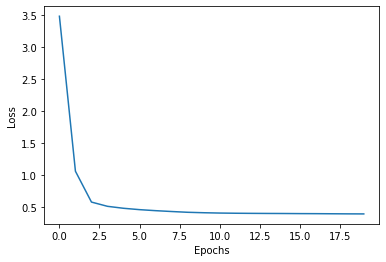

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

###Test

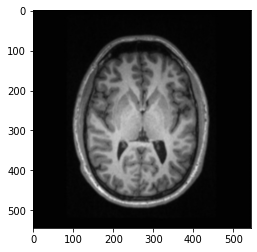

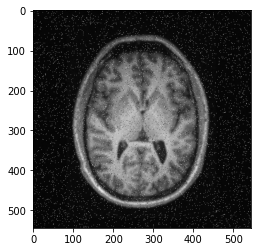

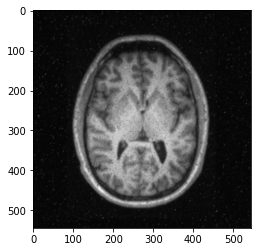

In [ ]:
index = 45
sample_test_img = np.expand_dims(x_train_noisy[index], axis=0)
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))
plt.figure()
plt.imshow(x_train[index],cmap = "gray")
plt.figure()
plt.imshow(x_train_noisy[index],cmap = "gray")
plt.figure()
plt.imshow(predicted_label,cmap="gray")

####Mean Squared Error

In [ ]:
def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the
	# sum of the squared difference between the two images;
	# NOTE: the two images must have the same dimension
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	
	# return the MSE, the lower the error, the more "similar"
	# the two images are
	return err

In [ ]:
mseList = 0
for i in range (len(x_train)):
  sample_test_img = np.expand_dims(x_train_noisy[i], axis=0)
  predicted_label = np.squeeze(autoencoder.predict(sample_test_img))
  mseList += mse(x_train[i],predicted_label)

In [ ]:
mseList/len(x_train)

0.0011629870468585681

####Calculate SSIM

In [ ]:
from skimage.metrics import structural_similarity as ssim
ssimList = 0
for i in range (len(x_train)):
  sample_test_img = np.expand_dims(x_train_noisy[i], axis=0)
  predicted_label = np.squeeze(autoencoder.predict(sample_test_img))
  ssimList += ssim(x_train[i], predicted_label)

In [ ]:
ssimList/len(x_train)

0.8669911842723957

####PSNR

In [ ]:
import math
def compute_psnr(img1, img2):
  img1 = img1.astype(np.float32) / 255.
  img2 = img2.astype(np.float32) / 255.
  mse = np.mean((img1 - img2) ** 2)
  if mse == 0:
    return "Same Image"
  return 10 * math.log10(1. / mse)

In [ ]:
psnrList = 0
for i in range (len(x_train)):
  sample_test_img = np.expand_dims(x_train_noisy[i], axis=0)
  predicted_label = np.squeeze(autoencoder.predict(sample_test_img))
  psnrList += compute_psnr(x_train[i], predicted_label)

In [ ]:
psnrList/len(x_train)

77.7338662735032

###Train II


In [ ]:
blurrList = []
for i in range (len(x_train_noisy)):
  sample_test_img = np.expand_dims(x_train_noisy[i], axis=0)
  predicted_label = np.squeeze(autoencoder.predict(sample_test_img))
  blurrList.append(predicted_label)
blurrList = np.array(blurrList)

In [ ]:
blurrList = np.float32(blurrList)

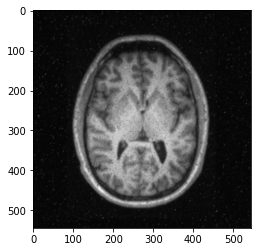

In [ ]:
plt.imshow(blurrList[45],cmap = 'gray')

In [ ]:
autoencoder2 = build_autoencoder()
autoencoder2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 544, 544, 1)]     0         
_________________________________________________________________
Conv10 (Conv2D)              (None, 544, 544, 16)      160       
_________________________________________________________________
upsample5 (UpSampling2D)     (None, 1088, 1088, 16)    0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 1088, 1088, 1)     145       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 544, 544, 1)       0         
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = autoencoder2.fit(blurrList, x_train, epochs=20)

Epoch 1/20
8/8 [==============================] - 5s 573ms/step - loss: 3.7822
Epoch 2/20
8/8 [==============================] - 5s 591ms/step - loss: 2.5964
Epoch 3/20
8/8 [==============================] - 5s 604ms/step - loss: 0.6610
Epoch 4/20
8/8 [==============================] - 5s 615ms/step - loss: 0.5308
Epoch 5/20
8/8 [==============================] - 5s 621ms/step - loss: 0.4811
Epoch 6/20
8/8 [==============================] - 5s 625ms/step - loss: 0.4518
Epoch 7/20
8/8 [==============================] - 5s 626ms/step - loss: 0.4328
Epoch 8/20
8/8 [==============================] - 5s 614ms/step - loss: 0.4215
Epoch 9/20
8/8 [==============================] - 5s 601ms/step - loss: 0.4111
Epoch 10/20
8/8 [==============================] - 5s 600ms/step - loss: 0.3999
Epoch 11/20
8/8 [==============================] - 5s 596ms/step - loss: 0.3946
Epoch 12/20
8/8 [==============================] - 5s 592ms/step - loss: 0.3942
Epoch 13/20
8/8 [==============================] 

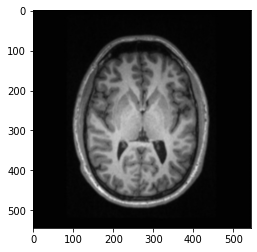

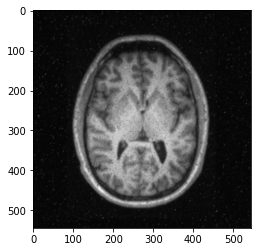

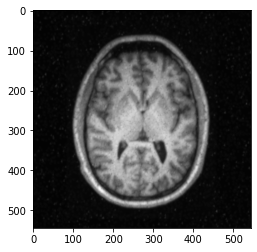

In [ ]:
index = 45
sample_test_img = np.expand_dims(blurrList[index], axis=0)
predicted_label = np.squeeze(autoencoder2.predict(sample_test_img))
plt.figure()
plt.imshow(x_train[index],cmap = "gray")
plt.figure()
plt.imshow(blurrList[index],cmap = "gray")
plt.figure()
plt.imshow(predicted_label,cmap="gray")

In [ ]:
mseList = 0
for i in range (len(x_train)):
  sample_test_img = np.expand_dims(blurrList[i], axis=0)
  predicted_label = np.squeeze(autoencoder2.predict(sample_test_img))
  mseList += mse(x_train[i],predicted_label)

In [ ]:
mseList/len(x_train)

0.0011039006713801556

In [ ]:
from skimage.metrics import structural_similarity as ssim
ssimList = 0
for i in range (len(x_train)):
  sample_test_img = np.expand_dims(x_train_noisy[i], axis=0)
  predicted_label = np.squeeze(autoencoder2.predict(sample_test_img))
  ssimList += ssim(x_train[i], predicted_label)

In [ ]:
ssimList/len(x_train)

0.7111305866293192

In [ ]:
psnrList = 0
for i in range (len(x_train)):
  sample_test_img = np.expand_dims(x_train_noisy[i], axis=0)
  predicted_label = np.squeeze(autoencoder2.predict(sample_test_img))
  psnrList += compute_psnr(x_train[i], predicted_label)

In [ ]:
psn2 = compute_psnr(test1,predicted_label2)

In [ ]:
psn2

66.01400467623377